<a href="https://colab.research.google.com/github/kavyajeetbora/EAST/blob/master/EAST_resnet_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Imports

[**Tasks - Incidental Scene Text**](https://rrc.cvc.uab.es/?ch=4&com=tasks)

In [0]:
import os
import time
from PIL import Image
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import shutil
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%%time
!rm -r /content/cloned-repo
%cd ..
!git clone -l -s git://github.com/kavyajeetbora/EAST.git /content/cloned-repo
%cd /content/cloned-repo
!ls

rm: cannot remove '/content/cloned-repo': No such file or directory
/
Cloning into '/content/cloned-repo'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 201 (delta 0), reused 0 (delta 0), pack-reused 199
Receiving objects: 100% (201/201), 10.81 MiB | 4.95 MiB/s, done.
Resolving deltas: 100% (115/115), done.
/content/cloned-repo
dataset.py		    EAST_detection.ipynb  loss.py	   train.py
detect.py		    EAST_resnet.py	  model.py
dsiplay_ground_truth.ipynb  EAST_training.ipynb   model_resnet.py
CPU times: user 118 ms, sys: 28.8 ms, total: 146 ms
Wall time: 14.7 s


In [0]:
from dataset import *

In [6]:
%%time

# AI4Bharat dataset
image_folder = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/AI4Bharat Dataset/Test Set/Images'
label_folder = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/AI4Bharat Dataset/Test Set/Annotations'

training_dataset = custom_dataset(image_folder, label_folder)
print(len(training_dataset))

428
CPU times: user 3.66 ms, sys: 1.24 ms, total: 4.91 ms
Wall time: 9.75 s


## Loss for one batch

In [7]:
%%time
train_loader = DataLoader(training_dataset, shuffle = True, batch_size=12, drop_last=True)
imgs, gt_score, gt_geo, ignored_maps = next(iter(train_loader))
print(imgs.size(), gt_score.size(), gt_geo.size(), ignored_maps.size())
print(torch.sum(gt_score))

torch.Size([12, 3, 512, 512]) torch.Size([12, 1, 128, 128]) torch.Size([12, 5, 128, 128]) torch.Size([12, 1, 128, 128])
tensor(18594.)
CPU times: user 4.54 s, sys: 6.4 s, total: 10.9 s
Wall time: 12.9 s


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
%%time
from EAST_resnet import East
model = East()
# pretrained_path = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/EAST scene text detector/model_epoch_50.pth'
model = model.to(device)
imgs, gt_score, gt_geo, ignored_maps = imgs.to(device), gt_score.to(device), gt_geo.to(device), ignored_maps.to(device)
pred_score, pred_geo = model(imgs)

print(pred_score.size(), pred_geo.size())

torch.Size([12, 1, 128, 128]) torch.Size([12, 5, 128, 128])
CPU times: user 2.99 s, sys: 1.32 s, total: 4.31 s
Wall time: 6.99 s


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [12]:
from loss import Loss

loss_fn = Loss()
loss_fn(gt_score, pred_score, gt_geo, pred_geo, ignored_maps)

classify loss is 0.83737850, angle loss is 0.02477184, iou loss is 2.65932226


tensor(3.7444, device='cuda:0', grad_fn=<AddBackward0>)

## Training Full Batch 

fine tuning pretrained model [east_vgg16.pth](https://drive.google.com/file/d/1AFABkJgr5VtxWnmBU3XcfLJvpZkC2TAg/view)

In [0]:
torch.cuda.empty_cache()

In [0]:
model = East()
model = model.to(device)

In [0]:
def train(model, train_img_path, train_gt_path, batch_size, lr, epoch_iter, num_workers=4, interval=1):
    file_num = len(os.listdir(train_img_path))
    print(file_num)
    trainset = custom_dataset(train_img_path, train_gt_path)
    train_loader = data.DataLoader(trainset, batch_size=batch_size, \
                                   shuffle=True, num_workers=num_workers, drop_last=True)
	
    criterion = Loss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=epoch_iter//25, gamma=0.5)
    loss_curve = []
    
    for epoch in range(epoch_iter):
      model.train()
      # scheduler.step()
      epoch_loss = 0
      epoch_time = time.time()
      for i, (img, gt_score, gt_geo, ignored_map) in enumerate(train_loader):
        start_time = time.time()
        img, gt_score, gt_geo, ignored_map = img.to(device), gt_score.to(device), gt_geo.to(device), ignored_map.to(device)
        pred_score, pred_geo = model(img)
        loss = criterion(gt_score, pred_score, gt_geo, pred_geo, ignored_map)

        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch is [{}/{}], mini-batch is [{}/{}], time consumption is {:.8f}, batch_loss is {:.8f}'.format(\
                  epoch+1, epoch_iter, i+1, int(file_num/batch_size), time.time()-start_time, loss.item()))
        
      print('epoch_loss is {:.8f}, epoch_time is {:.8f}'.format(epoch_loss/int(file_num/batch_size), time.time()-epoch_time))
      print(time.asctime(time.localtime(time.time())))
      print('='*50)
      
      
      if (epoch + 1) % interval == 0:
        state_dict = model.state_dict()
        torch.save(state_dict, 'model_epoch_{}.pth'.format(epoch+1))
       
      ## plotting the loss curve
      loss_curve.append(epoch_loss/int(file_num/batch_size))

    return loss_curve

In [17]:
%%time
loss_curve = train(model, image_folder, label_folder, batch_size=8, lr=1e-4, epoch_iter=50, interval = 10)

428


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


classify loss is 0.86550081, angle loss is 0.01341850, iou loss is 2.74731970
Epoch is [1/50], mini-batch is [1/53], time consumption is 0.29608607, batch_loss is 3.74700546
classify loss is 0.82145220, angle loss is 0.01499552, iou loss is 2.63413095
Epoch is [1/50], mini-batch is [2/53], time consumption is 0.27126288, batch_loss is 3.60553837
classify loss is 0.87795037, angle loss is 0.00815951, iou loss is 1.82841909
Epoch is [1/50], mini-batch is [3/53], time consumption is 0.26961946, batch_loss is 2.78796458
classify loss is 0.84596491, angle loss is 0.01735657, iou loss is 2.50503540
Epoch is [1/50], mini-batch is [4/53], time consumption is 0.26813769, batch_loss is 3.52456594
classify loss is 0.83232182, angle loss is 0.00411106, iou loss is 2.45597386
Epoch is [1/50], mini-batch is [5/53], time consumption is 0.29036236, batch_loss is 3.32940626
classify loss is 0.84105068, angle loss is 0.02182223, iou loss is 2.05901742
Epoch is [1/50], mini-batch is [6/53], time consumpt

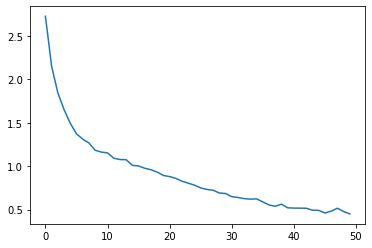

In [18]:
plt.plot(loss_curve)

1. [**Adam and AdamW algorithms**](https://www.fast.ai/2018/07/02/adam-weight-decay/)

2. [**The optimal learning rate during fine-tuning of an artificial neural network**](https://www.mikulskibartosz.name/the-optimal-learning-rate-during-fine-tuning-of-an-artificial-neural-network/)

In [0]:
state_dict = torch.load('/content/cloned-repo/model_epoch_50.pth')